<a href="https://colab.research.google.com/github/Telephos/Filters/blob/main/Filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In Part 1 how to apply a linear box filter on an image with varying kernel sizes, and in Part 2 how to use native functions from OpenCV to do the same. 

We begin by importing all the libraries we will be needing.

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image

We import our images into RGB format.

In [ ]:
img_dog = cv.imread('dog.bmp')[:,:,::-1]
img_bike = cv.imread('bicycle.bmp')[:,:,::-1]

### Part 1 - 3x3 & 5x5 user created box filter
Here we are using a Box Filter generated from scratch largely from this resource online:
https://moicapnhap.com/gaussian-filter-python-from-scratch

Since we are implementing a Box Filter rather than a Gaussian, several simplifications are made to the original code and comments are added for clarity. 

In [ ]:
def convolution(oldimage, kernel):
    image_h = oldimage.shape[0] #Height of image
    image_w = oldimage.shape[1] #Width of image
    kernel_h = kernel.shape[0] #Height of kernel
    kernel_w = kernel.shape[1] #Width of kernel

    #If the image has 3 channels padding of constant value is applied to all 
    if(len(oldimage.shape) == 3):
        image_pad = np.pad(oldimage, 
                           pad_width=((kernel_h // 2, kernel_h // 2),
                                      (kernel_w // 2, kernel_w // 2),
                                      (0,0)),
                                       mode='constant',
                                       constant_values=0).astype(np.float32)
    #Padding for single channel image
    elif(len(oldimage.shape) == 2):
        image_pad = np.pad(oldimage,
                           pad_width=((kernel_h // 2, kernel_h // 2),
                                      (kernel_w // 2, kernel_w // 2)),
                                       mode='constant',
                                       constant_values=0).astype(np.float32)
    
    #Floor division to determine where to begin convolving from. A (5x5) matrix -> 5//2 = 2
    h = kernel_h // 2
    w = kernel_w // 2

    #print(image_pad.shape)
    #Create a matrix of zeroes with padding into which the convolved values are placed.
    image_conv = np.zeros(image_pad.shape)

    for i in range(h, image_pad.shape[0]-h):
        for j in range(w, image_pad.shape[1]-w):
            #sum = 0
            #The sub-matrices are selected and flattened into arrays so we can determine the sum of dot products.
            x = image_pad[i-h:i-h+kernel_h, j-w:j-w+kernel_w]
            #When I declare an np matrix instead of a native Python matrix, I have to convert it to a 1d vector
            #Very annoying, but I have to check the shape of the kernel after flattening. 
            #Native python matrix flattens into (d,) vector while np matrix flattens into (1,d) vector
            #The lines below just check this condition.
            if(kernel.flatten().shape[0] == 1):
                x = x.flatten()*np.ravel(kernel)
                image_conv[i][j] = x.sum()
            else:
                x = x.flatten()*kernel.flatten()
                image_conv[i][j] = x.sum()
            
    h_end = -h
    w_end = -w

    #Cases for kernels of size 1.
    if(h == 0):
        return image_conv[h:,w:w_end]
    if(w == 0):
        return image_conv[h:h_end,w:]

    return image_conv[h:h_end,w:w_end]

The boxFilter() function is a matrix of ones divided by the square of one of the kernel's dimensions.

In [ ]:
#Provide filename of image as first argument and kernel size -- (3x3) = 3, etc. 
def boxFilter(image, k_size):
    image = Image.open(image) #Open image with Pillow library
    image = np.asarray(image) #Convert pixel values to Numpy array

    #Below creates an empty matrix with the same dimensions as our image, into which we'll placed the convolved values
    im_filtered = np.zeros_like(image, dtype=np.float32) 
    
    #Iterate through the channels, convolving 
    for c in range(3):
        #Call convolution function 
        im_filtered[:, :, c] = convolution(image[:, :, c], np.ones((k_size,k_size), np.float32)/(k_size**2))

    #We convert the return the array into an image and return that image, ending the function
    return Image.fromarray((im_filtered.astype(np.uint8)))

Below we show the result of applying a 3x3 box filter to the images.

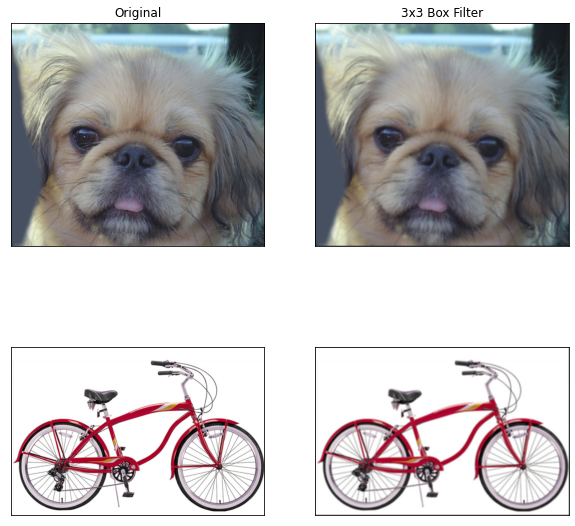

In [ ]:
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

#test_im = Sobel3x3("dog.bmp", 1)

#Produces 3x3 gaussian filter
dog_box_3x3 = boxFilter("dog.bmp", 3)
plt.subplot(222)
plt.imshow(dog_box_3x3)
plt.title('3x3 Box Filter')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_box_3x3 = boxFilter("bicycle.bmp", 3)
plt.subplot(224)
plt.imshow(bike_box_3x3)
plt.xticks([])
plt.yticks([])

plt.savefig('3x3boxFilter_user.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

And now a 5x5 box filter to the images.

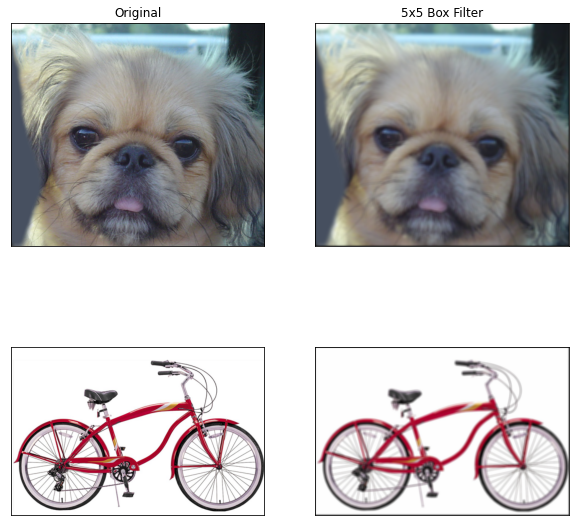

In [ ]:
plt.clf()
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

#test_im = Sobel3x3("dog.bmp", 1)

#Produces 3x3 gaussian filter
dog_box_5x5 = boxFilter("dog.bmp", 5)
plt.subplot(222)
plt.imshow(dog_box_5x5)
plt.title('5x5 Box Filter')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_box_5x5 = boxFilter("bicycle.bmp", 5)
plt.subplot(224)
plt.imshow(bike_box_5x5)
plt.xticks([])
plt.yticks([])

plt.savefig('5x5boxFilter_user.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

### Part 2 - 3x3 & 5x5 OpenCV box filter

In order to see the use of OpenCV box filter function. The documentation was followed here:

https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

In [ ]:
#Defining our 3x3 kernel
kernel3 = np.ones((3,3), np.float32)/(3**2)

We can then call our filter2D function from OpenCV to apply the box filter. 

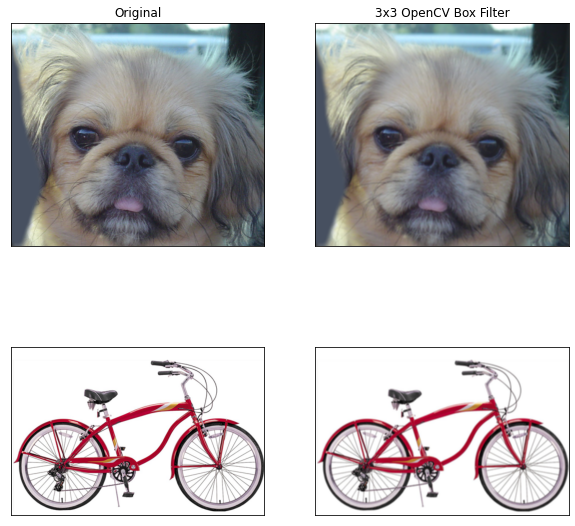

In [ ]:
plt.clf()
dog_cvBox_3x3 = cv.filter2D(img_dog,-1,kernel3)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_cvBox_3x3)
plt.title('3x3 OpenCV Box Filter')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_cvBox_3x3 = cv.filter2D(img_bike,-1,kernel3)
plt.subplot(224)
plt.imshow(bike_cvBox_3x3)
plt.xticks([])
plt.yticks([])

plt.savefig('3x3boxFilter_openCV.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

Now with a kernel size of 5x5

In [ ]:
kernel5 = np.ones((5,5), np.float32)/(5**2)

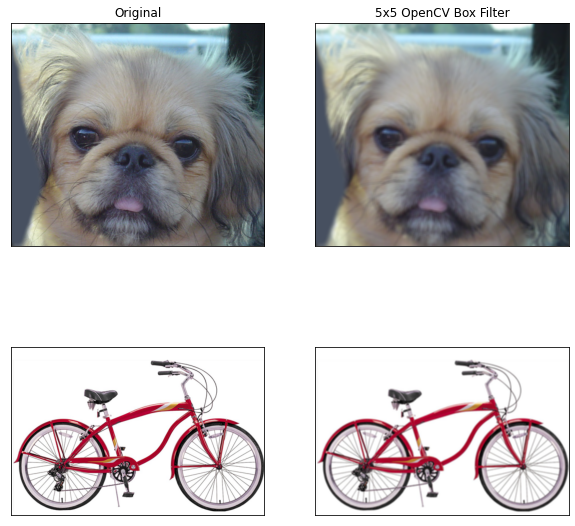

In [ ]:
plt.clf()
dog_cvBox_5x5 = cv.filter2D(img_dog,-1,kernel5)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_cvBox_5x5)
plt.title('5x5 OpenCV Box Filter')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_cvBox_5x5 = cv.filter2D(img_bike,-1,kernel3)
plt.subplot(224)
plt.imshow(bike_cvBox_5x5)
plt.xticks([])
plt.yticks([])

plt.savefig('5x5boxFilter_openCV.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

### Part 3 - Sobel Filter: X-axis for user defined function

Here we are going to use the previously mentioned resource (see [1]) to create a new function for the Sobel filter.

In [ ]:
def Sobel3x3(image, ax):
    image = Image.open(image)
    image = np.asarray(image)
    
    #Hardcoding the values of the sobel filter
    sobel_x = np.matrix('1, 0, -1; 2, 0, -2; 1, 0, -1', np.float32)
    sobel_y = np.matrix('1, 2, 1; 0, 0, 0; -1, -2, -1', np.float32)
    
    im_filtered = np.zeros_like(image, dtype=np.float32)
    
    #We can choose which axes to apply the filter toward.
    if(ax == 1):
        for c in range(3):
            im_filtered[:, :, c] = convolution(image[:, :, c], sobel_x)
    elif(ax == 2):
        for c in range(3):
            im_filtered[:, :, c] = convolution(image[:, :, c], sobel_y)
    elif(ax == 3):
        for c in range(3):
            im_filtered[:, :, c] = convolution(image[:, :, c], sobel_x)
            im_filtered[:, :, c] += convolution(image[:, :, c], sobel_y)
    else:
        print("2nd argument must be 1(x), 2(y), or 2(x&y) for sobel operation")
        return
    
    return Image.fromarray((im_filtered.astype(np.uint8)))

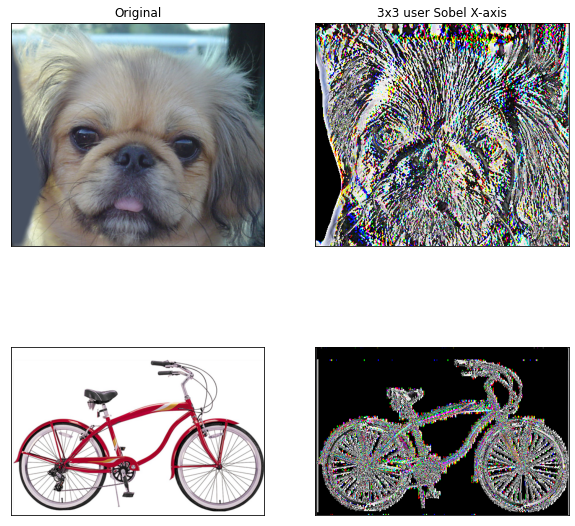

In [ ]:
plt.clf()
dog_Sobelx_3x3 = Sobel3x3("dog.bmp", 1)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_Sobelx_3x3)
plt.title('3x3 user Sobel X-axis')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_Sobelx_3x3 = Sobel3x3("bicycle.bmp", 1)
plt.subplot(224)
plt.imshow(bike_Sobelx_3x3)
plt.xticks([])
plt.yticks([])

plt.savefig('3x3SobelX_user.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

We will now define a new function for the 5x5 Sobel filter.

In [ ]:
def Sobel5x5(image, ax):
    image = Image.open(image)
    image = np.asarray(image)
    
    sobel_x = np.matrix('2, 2, 4, 2, 2; 1, 1, 2, 1, 1; 0, 0, 0, 0, 0; -1, -1, -2, -1, -1; -2, -2, -4, -2, -2', np.float32)
    sobel_y = np.matrix('2, 1, 0, -1, -2; 2, 1, 0, -1, -2; 4, 2, 0, -2, -4; 2, 1, 0, -1, -2; 2, 1, 0, -1, -2', np.float32)
    
    im_filtered = np.zeros_like(image, dtype=np.float32)
    
    if(ax == 1):
        for c in range(3):
            im_filtered[:, :, c] = convolution(image[:, :, c], sobel_x)
    elif(ax == 2):
        for c in range(3):
            im_filtered[:, :, c] = convolution(image[:, :, c], sobel_y)
    elif(ax == 3):
        for c in range(3):
            im_filtered[:, :, c] = convolution(image[:, :, c], sobel_x)
            im_filtered[:, :, c] += convolution(image[:, :, c], sobel_y)
    else:
        print("2nd argument must be 1(x), 2(y), or 2(x&y) for sobel operation")
        return
    
    return Image.fromarray((im_filtered.astype(np.uint8)))

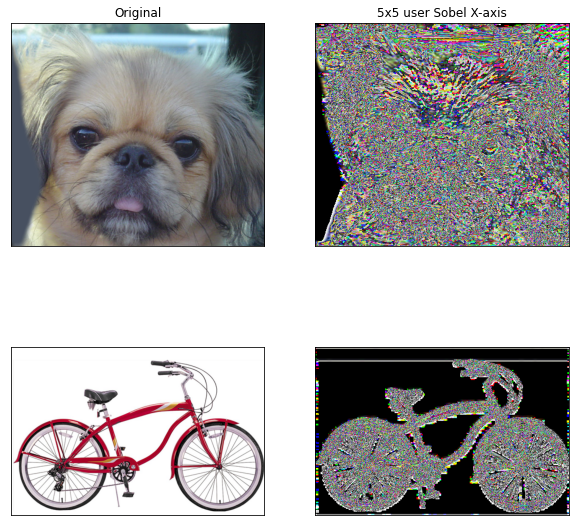

In [ ]:
plt.clf()
dog_Sobelx_5x5 = Sobel5x5("dog.bmp", 1)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_Sobelx_5x5)
plt.title('5x5 user Sobel X-axis')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_Sobelx_5x5 = Sobel5x5("bicycle.bmp", 1)
plt.subplot(224)
plt.imshow(bike_Sobelx_5x5)
plt.xticks([])
plt.yticks([])

plt.savefig('5x5SobelX_user.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

### Part 4 - Sobel Filter: Y-axis for user defined function

In this part, we apply the user defined Sobel filter only to the Y-axis

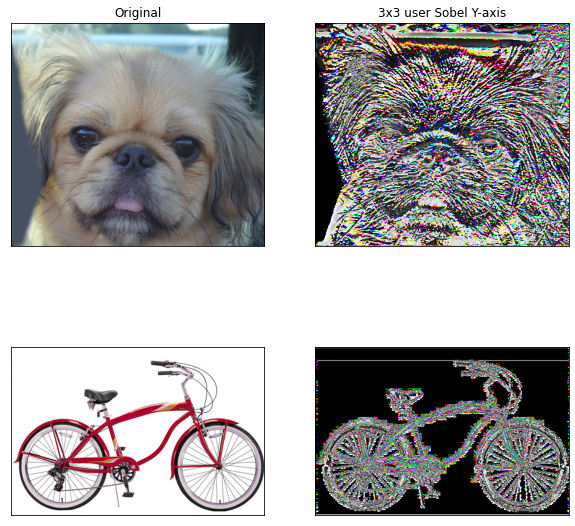

In [ ]:
plt.clf()
dog_Sobely_3x3 = Sobel3x3("dog.bmp", 2)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_Sobely_3x3)
plt.title('3x3 user Sobel Y-axis')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_Sobely_3x3 = Sobel3x3("bicycle.bmp", 2)
plt.subplot(224)
plt.imshow(bike_Sobely_3x3)
plt.xticks([])
plt.yticks([])

plt.savefig('3x3SobelyY_user.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

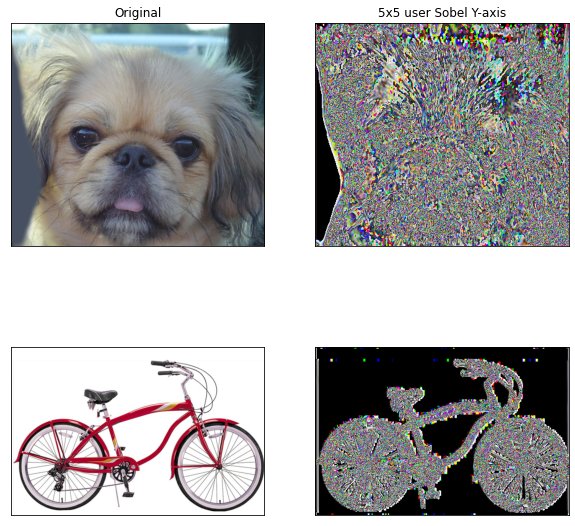

In [ ]:
plt.clf()
dog_Sobely_5x5 = Sobel5x5("dog.bmp", 2)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_Sobely_5x5)
plt.title('5x5 user Sobel Y-axis')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_Sobely_5x5 = Sobel5x5("bicycle.bmp", 2)
plt.subplot(224)
plt.imshow(bike_Sobely_5x5)
plt.xticks([])
plt.yticks([])

plt.savefig('5x5SobelyY_user.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

### Part 5 - Sobel Filter: X&Y-axis for user defined function

We know use the second argument in our function to specify that both the X&Y axis should be convolved with the Sobel kernel (3x3)

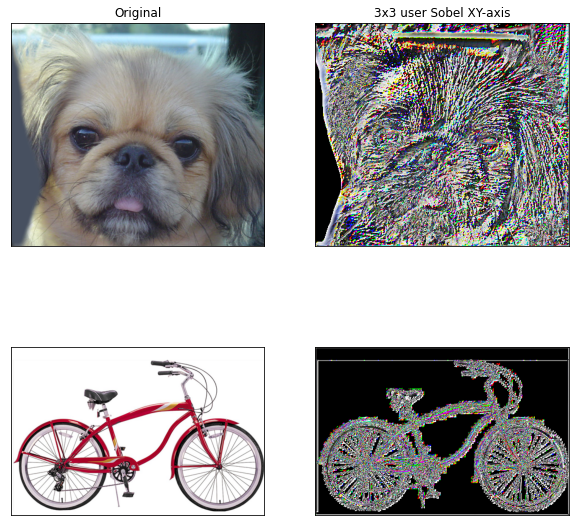

In [ ]:
plt.clf()
dog_Sobelxy_3x3 = Sobel3x3("dog.bmp", 3)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_Sobelxy_3x3)
plt.title('3x3 user Sobel XY-axis')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_Sobelxy_3x3 = Sobel3x3("bicycle.bmp", 3)
plt.subplot(224)
plt.imshow(bike_Sobelxy_3x3)
plt.xticks([])
plt.yticks([])

plt.savefig('3x3SobelyXY_user.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

Now we can use the 5x5 kernel

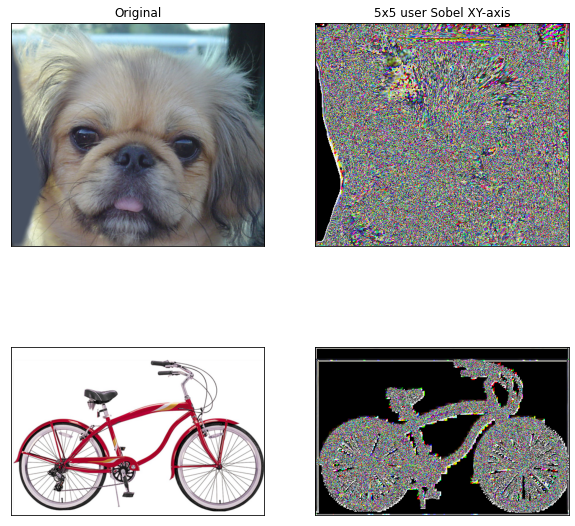

In [ ]:
plt.clf()
dog_Sobelxy_5x5 = Sobel5x5("dog.bmp", 3)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_Sobelxy_5x5)
plt.title('5x5 user Sobel XY-axis')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_Sobelxy_5x5 = Sobel5x5("bicycle.bmp", 3)
plt.subplot(224)
plt.imshow(bike_Sobelxy_5x5)
plt.xticks([])
plt.yticks([])

plt.savefig('5x5SobelyXY_user.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

### Part 6 - Sobel Filter: X&Y-axis with OpenCV

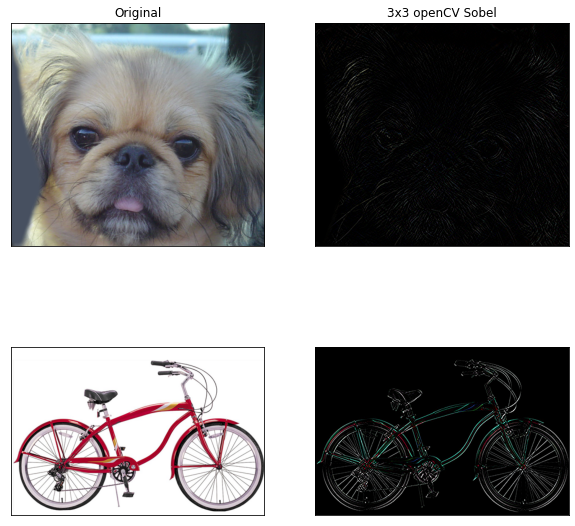

In [ ]:
plt.clf()
dog_cvSobel_3x3 = cv.Sobel(img_dog,-1, dx=1, dy=1, ksize=3)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_cvSobel_3x3)
plt.title('3x3 openCV Sobel')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_cvSobel_3x3 = cv.Sobel(img_bike,-1, dx=1, dy=1, ksize=3)
plt.subplot(224)
plt.imshow(bike_cvSobel_3x3)
plt.xticks([])
plt.yticks([])

plt.savefig('3x3Sobel_openCV.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

We can now use OpenCV's Sobel filter with a kernel size of 5x5

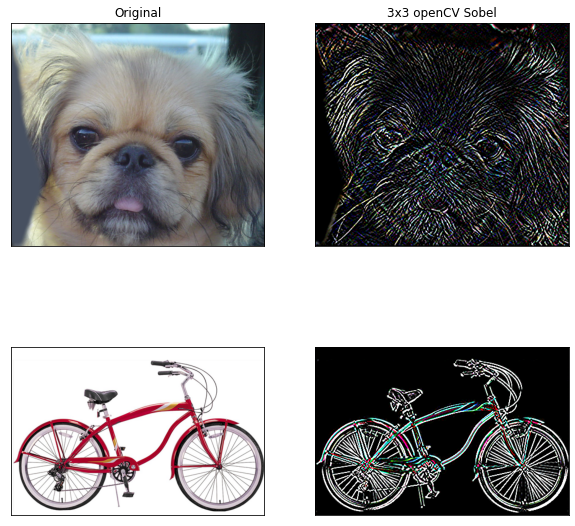

In [ ]:
plt.clf()
dog_cvSobel_5x5 = cv.Sobel(img_dog,-1, dx=1, dy=1, ksize=5)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_cvSobel_5x5)
plt.title('3x3 openCV Sobel')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_cvSobel_5x5 = cv.Sobel(img_bike,-1, dx=1, dy=1, ksize=5)
plt.subplot(224)
plt.imshow(bike_cvSobel_5x5)
plt.xticks([])
plt.yticks([])

plt.savefig('5x5Sobel_openCV.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

### Part 7 - Gaussian Filter with OpenCV

Documentation: https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1

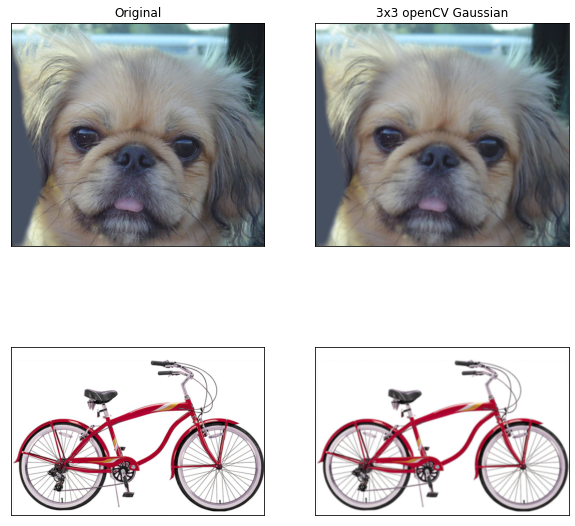

In [ ]:
plt.clf()
dog_cvGauss_3x3 = cv.GaussianBlur(img_dog,(3,3),0)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_cvGauss_3x3)
plt.title('3x3 openCV Gaussian')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_cvGauss_3x3 = cv.GaussianBlur(img_bike,(3,3),0)
plt.subplot(224)
plt.imshow(bike_cvGauss_3x3)
plt.xticks([])
plt.yticks([])

plt.savefig('3x3Gaussian_openCV.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()

Now using a 5x5 kernel for the Gaussian

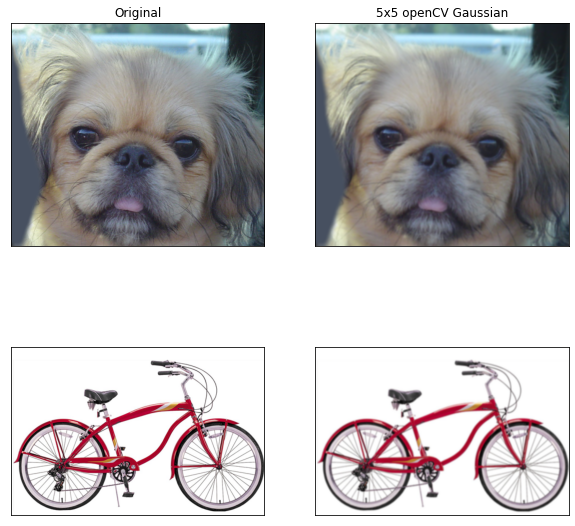

In [ ]:
plt.clf()
dog_cvGauss_5x5 = cv.GaussianBlur(img_dog,(5,5),0)
plt.subplot(221)
#plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img_dog)
plt.title('Original')
plt.xticks([]) 
plt.yticks([])

plt.subplot(222)
plt.imshow(dog_cvGauss_5x5)
plt.title('5x5 openCV Gaussian')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(img_bike)
plt.xticks([])
plt.yticks([])

bike_cvGauss_5x5 = cv.GaussianBlur(img_bike,(5,5),0)
plt.subplot(224)
plt.imshow(bike_cvGauss_5x5)
plt.xticks([])
plt.yticks([])

plt.savefig('5x5Gaussian_openCV.png', format='png', bbox_inches='tight', dpi=200, facecolor='w')
plt.show()